In [1]:
%reload_ext autoreload
%autoreload 2

In [37]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import assembly_multi_region
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
from neo.rawio import neuroscoperawio
import nelpy.plotting as npl

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [3]:
import pickle
session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_HMC1_day10.pkl"
# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_AYAold_AYA9_day15.pkl"

# Z:\Data\AYAold\AYA9\day15
with open(session, "rb") as f:
    results = pickle.load(f)

In [22]:
from xml.etree import ElementTree
def parse_xml_channel_groups(filename):
    filename = filename.replace('.xml', '').replace('.dat', '')

    tree = ElementTree.parse(filename + '.xml')
    root = tree.getroot()

    # find channels
    channel_group = []
    for grp_index, xml_chx in enumerate(
            root.find('anatomicalDescription').find('channelGroups').findall('group')):
        for xml_rc in xml_chx:
            channel_group.append([int(xml_rc.text),grp_index])
    return np.array(channel_group)

reader = neuroscoperawio.NeuroScopeRawIO('Z:/Data/HMC1/day10/day10')
reader.parse_header()
channel_group = parse_xml_channel_groups(reader.filename)
shank = 9
channel_indexes = channel_group[channel_group[:,1] == shank,0]

In [23]:
channel_indexes

array([288, 301, 306, 319, 302, 305, 289, 303, 304, 290, 300, 307, 291,
       299, 308, 292, 298, 309, 293, 297, 310, 318, 296, 311, 317, 295,
       312, 316, 294, 313, 315, 314])

In [28]:
channel_indexes = [293,314]
rip = 0
seconds_idx = np.array([results["react"].ripples[rip].start,results["react"].ripples[rip].stop])

# convert to index
to_idx = (seconds_idx*reader.get_signal_sampling_rate()).astype(int)
# get chunk of data
raw_sigs = reader.get_analogsignal_chunk(i_start=to_idx[0],
                                        i_stop=to_idx[1],
                                        channel_indexes=channel_indexes)

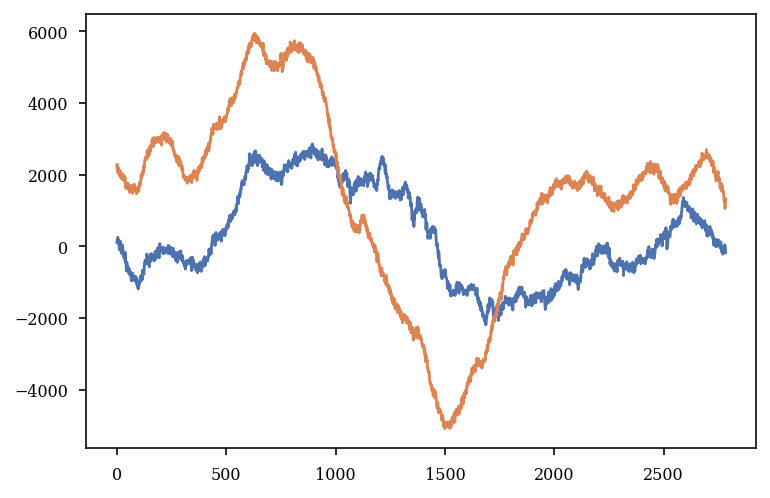

In [29]:
plt.plot(raw_sigs)

In [12]:
results

{'assembly_act_pre': <AnalogSignalArray at 0x1f265093490: 45 signals (4,052 segments)> for a total of 12:33:524 minutes,
 'assembly_act_task': <AnalogSignalArray at 0x1f26509d8e0: 45 signals (776 segments)> for a total of 2:11:762 minutes,
 'assembly_act_post': <AnalogSignalArray at 0x1f26509dbe0: 45 signals (5,227 segments)> for a total of 16:20:389 minutes,
 'react': <ripple_heterogeneity.assembly.assembly_reactivation.AssemblyReact at 0x1f26509de20>}

In [13]:
patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(
    results.get("react").patterns
)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
# keep_assembly

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


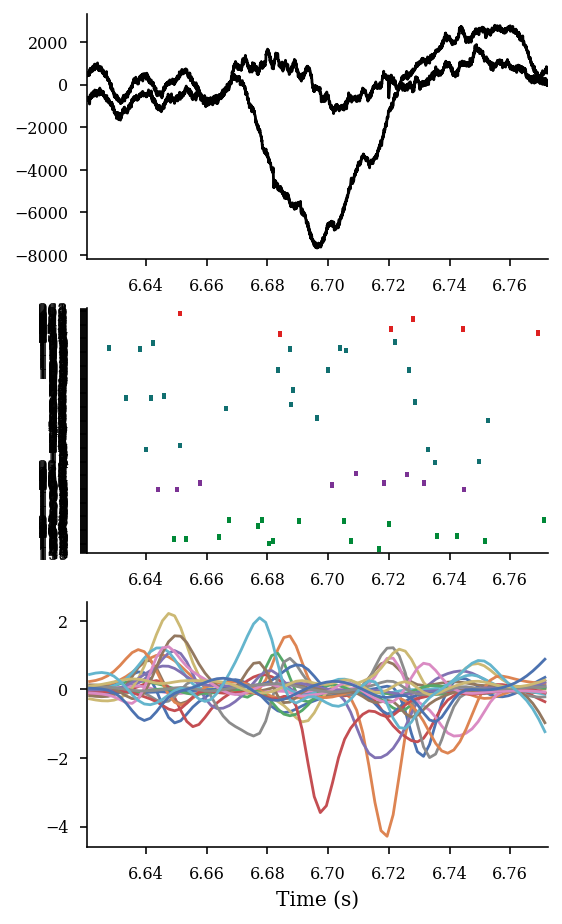

In [46]:
rip = 2

fig, axs = plt.subplots(3,1,figsize=functions.set_size("thesis", fraction=0.7, subplots=(3, 1)),edgecolor=None)
fig.subplots_adjust(hspace=.2, wspace=0.1)
axs = axs.ravel()

# plot raw signal
channel_indexes = [293, 314]

seconds_idx = np.array(
    [results["react"].ripples[rip].start, results["react"].ripples[rip].stop]
)
# convert to index
to_idx = (seconds_idx * reader.get_signal_sampling_rate()).astype(int)
# get chunk of data
raw_sigs = reader.get_analogsignal_chunk(
    i_start=to_idx[0], i_stop=to_idx[1], channel_indexes=channel_indexes
)
ts = np.linspace(
    results["react"].ripples[rip].start,
    results["react"].ripples[rip].stop,
    raw_sigs.shape[0],
)

axs[0].plot(ts, raw_sigs, color="k")

# plot raster
group_colors = {
    "MEC": "#de2020",
    "PFC": "#116f70",
    "Deep": "#7b3294",
    "Superficial": "#008837",
}
ca1_deep_idx = results["react"].cell_metrics.brainRegion.str.contains("CA1") & results[
    "react"
].cell_metrics.deepSuperficial.str.contains("Deep")
ca1_sup_idx = results["react"].cell_metrics.brainRegion.str.contains("CA1") & results[
    "react"
].cell_metrics.deepSuperficial.str.contains("Superficial")
pfc_idx = results["react"].cell_metrics.brainRegion.str.contains("PFC")
mec_idx = results["react"].cell_metrics.brainRegion.str.contains("MEC")

npl.rasterplot(
    results["react"].st.iloc[:, ca1_sup_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["Superficial"],
    vertstack=True,
)
npl.rasterplot(
    results["react"].st.iloc[:, ca1_deep_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["Deep"],
    vertstack=True,
)
npl.rasterplot(
    results["react"].st.iloc[:, pfc_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["PFC"],
    vertstack=True,
)
npl.rasterplot(
    results["react"].st.iloc[:, mec_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["MEC"],
    vertstack=True,
)

# plot assembly strength
axs[2].plot(
    results["assembly_act_pre"][results["react"].ripples[rip]].abscissa_vals,
    results["assembly_act_pre"][results["react"].ripples[rip]].data[keep_assembly].T,
)
sns.despine()
axs[2].set_xlabel("Time (s)")

for ax in axs:
    ax.set_xlim(results["react"].ripples[rip].start, results["react"].ripples[rip].stop)